# EKF-SLAM
Extended Kahlman Filter for Simultanious Localization and Mapping

## Imports

In [465]:
import numpy as np
import math
import json

from ekf_slam import EKFSlam

## Algorithm: EKF SLAM

In [466]:
slam = EKFSlam()

# Save Simulation
x_hist = []
P_hist = []
R_hist = []

# Init SLAM
W = (slam.cloister(-4,4,-4,4,7)).T      # (36,2)
N = W.shape[0]                          # int: Number of landmarks
R = np.array([0.0, -2.0, 0.0])          # robot initial pose [x, y, alpha]
U = np.array([0.1, 0.05])               # control vector, advance and turn increments (creates a circle)
Y = np.zeros((N,2))                     # measurements of all landmarks
     
# Estimator     
# Map: Gaussian {x,P}     
x = np.zeros(R.size + W.size)           # state vector's mean
P = np.zeros((x.size, x.size))          # state vectors covariances matrix
     
# System Noise: Gaussian {0, Q}     
q = np.array([0.01, 0.02])              # amplitude or standard deviation
Q = np.diag(q**2)                       # covariances matrix

# Measurement Noise: Gaussian {0, S}
s = np.array([0.1,math.pi/180])
S = np.diag(s**2)

# Map Management
mapspace = np.zeros(x.size, dtype=bool) # Help Note 10
landmarks = np.zeros((N, 2))            # Help Note 11

# Place Robot in Map
r = np.where(~mapspace)[0][:R.size]     # Robot Pointer for accessing state vector
mapspace[r] = True
x[r] = R

# Add Ground Truth as first state in History
x_hist.append(np.hstack((R, W.flatten())))
P_hist.append(P.copy())
R_hist.append(R.copy())

# Temporal Loop
for t in range(0, 200):
    # Motion    
    n = q * np.random.randn(2)         # perturbation vector
    R = slam.move(R, U, np.zeros((2))) # Move the robot
    for i in range(0,N):               # i landmark index
        v = s * np.random.randn(2)     # measurement noise
        Y[i, :] = slam.observe(R, W[i, :]) + v
    m = landmarks[landmarks != 0].T.astype(int)
    rm = np.hstack([r, m]).astype(int)
    # Predict
    x[r], R_r, R_n = slam.move(x[r], U, n, jacobians=True)

    if m.size > 0:
        P[np.ix_(r, m)] = R_r @ P[np.ix_(r, m)]
        P[np.ix_(m,r)] = P[np.ix_(r,m)].T
    P[np.ix_(r, r)] = (R_r @ P[np.ix_(r, r)] @ R_r.T + R_n @ Q @ R_n.T)
    
    lids = np.where(landmarks[0, :] != 0)[0]
    for i in lids:
        # expectation: Gaussian {e,E}
        l = landmarks[i, :].T.astype(int)                      # landmark pointer
        e, E_r, E_l = slam.observe(x[r], x[l], jacobians=True) # this is h(x) in EKF
        rl = np.hstack([r , l]).astype(int)                    # pointers to robot and lmk.
        E_rl = np.hstack([E_r , E_l])                          # expectation Jacobian
        E = E_rl @ P[np.ix_(rl, rl)] @ E_rl.T
        # measurement of landmark i
        Yi = Y[i, :]
        # innovation: Gaussian {z,Z}
        z = Yi - e                                             # this is z = y − h(x) in EKF
        # we need values around zero for angles:
        if z[1] > math.pi:
            z[1] = z[1] - 2*math.pi
        if z[1] < -math.pi:
            z[1] = z[1] + 2*math.pi
        Z = S + E
        # Individual compatibility check at Mahalanobis distance of 3−sigma
        # (See appendix of documentation file 'SLAM course.pdf')
        Z_inv = np.linalg.inv(Z)
        d2 = float(z.T @ Z_inv @ z)
        if d2 < 9:
            # Kalman gain
            K = P[np.ix_(rm, rl)] @ E_rl.T @ Z_inv             # this is K = P*H'*Zˆ−1 in EKF
            # map update (use pointer rm)
            x[rm] = x[rm] + K @ z
            P[np.ix_(rm,rm)] = P[np.ix_(rm,rm)] - K @ Z @ K.T
            
    # Landmark Initialization −− one new landmark only at each iteration
    lids = np.where(landmarks[:, 0] == 0)[0]                   # all non−initialized landmarks
    if len(lids) > 0:                                          # there are still landmarks to initialize
        i = np.random.choice(lids)                             # pick one landmark randomly, its index is i
        l = np.flatnonzero(~mapspace)[:2]                      # pointer of the new landmark in the map
        if len(l) > 0:                                         # there is still space in the map
            mapspace[l] = True                                 # block map space
            landmarks[i,:] = l                                 # store landmark pointers
            # measurement
            Yi = Y[i,:]
            # initialization
            x[l], L_r, L_y = slam.invObserve(x[r], Yi, jacobians=True)
            P[np.ix_(l,rm)] = L_r @ P[np.ix_(r,rm)]
            P[np.ix_(rm,l)] = P[np.ix_(l,rm)].T
            P[np.ix_(l,l)] = L_r @ P[np.ix_(r,r)] @ L_r.T + L_y @ S @ L_y.T
            
    x_hist.append(x.copy())
    P_hist.append(P.copy())
    R_hist.append(R.copy())
    
    l_init = x[3:].reshape(36,2)
    l_init = l_init[~np.all(l_init == 0, axis=1)]
    

## Summary Statistics
To analyize the effectiveness of our implementation we calculate 3 metrics

### Euclidean Error
This is how far, in units, the median (the location found in the state vecotr) is from the true value

### Mahalanobis distance
A measure of how far a point is from the center of a distribution. Takes into account the covariance of the variable.

#### Squared Mahalanobis distance
Because the squared Mahalanobis distance of a correctly estimated 2D landmark follows a chi-square distribution with 2 degrees of freedom, the expected value is 2. This gives us a principled benchmark for filter consistency

In [ ]:
final_x = x_hist[-1]      # (75,)
final_P = P_hist[-1]      # (75,75)

distances = []
euclid = []

for i in range(N):
    l = landmarks[i, :].astype(int)

    # true and estimated positions (2D)
    true_pos = W[i, :]
    est_pos  = final_x[l]

    # covariance block for landmark
    P_ll = final_P[np.ix_(l, l)]

    # Euclidean error
    diff = true_pos - est_pos
    euclid.append(float(np.linalg.norm(diff)))

    # Mahalanobis distance
    invP_ll = np.linalg.inv(P_ll)
    d2 = diff.T @ invP_ll @ diff
    d = d2**0.5

    distances.append(d)
    
distances = np.array(distances)
euclid = np.array(distances)
    
d2 = distances**2

print(f"mean Mahalanobis: {distances.mean():.2f}")
print(f"mean Euclidean  : {euclid.mean():.2f}")
print(f"mean d^2        : {d2.mean():.2f}")

mean Mahalanobis: 1.13
mean Euclidean  : 1.13
mean d^2        : 1.67


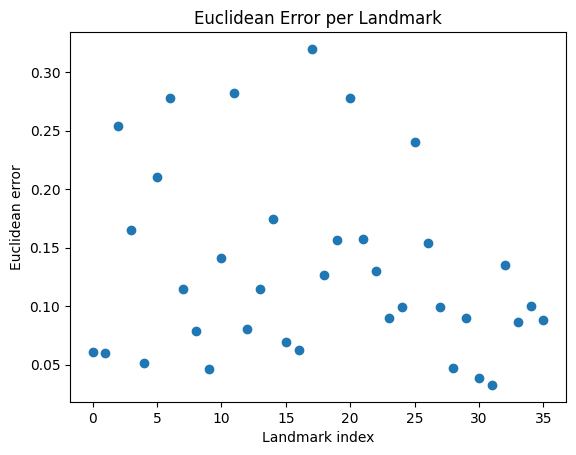

In [468]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(range(len(euclid)), euclid, marker='o')
ax.set_xlabel("Landmark index")
ax.set_ylabel("Euclidean error")
ax.set_title("Euclidean Error per Landmark")

plt.show()


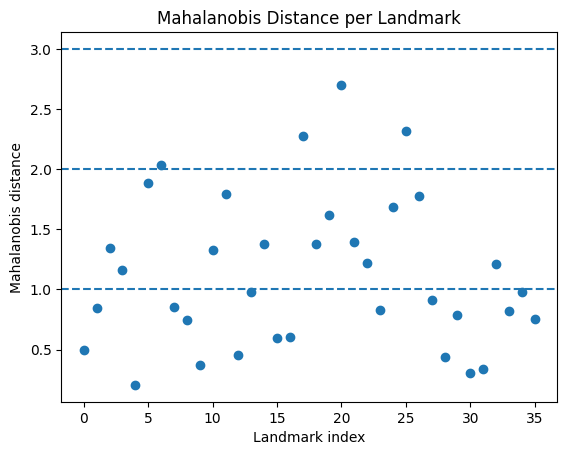

In [469]:
fig, ax = plt.subplots()

ax.scatter(range(len(distances)), distances, marker='o')
ax.set_xlabel("Landmark index")
ax.set_ylabel("Mahalanobis distance")
ax.set_title("Mahalanobis Distance per Landmark")

# Optional: show 1σ, 2σ, 3σ reference lines
for level in [1, 2, 3]:
    ax.axhline(level, linestyle='--')

plt.show()


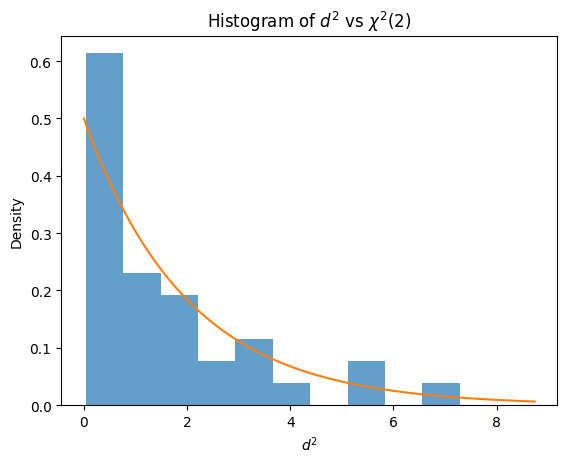

In [470]:
import numpy as np
import matplotlib.pyplot as plt

d2 = distances**2

fig, ax = plt.subplots()

# Histogram of observed d^2
ax.hist(d2, bins=10, density=True, alpha=0.7)
ax.set_xlabel(r"$d^2$")
ax.set_ylabel("Density")
ax.set_title(r"Histogram of $d^2$ vs $\chi^2(2)$")

# Theoretical chi-square(2) pdf: f(x) = 0.5 * exp(-x/2)
x_vals = np.linspace(0, max(d2)*1.2, 200)
chi2_pdf = 0.5 * np.exp(-x_vals / 2)

ax.plot(x_vals, chi2_pdf)

plt.show()


## Save Results
Save results to jsonl file where each line is a time step in the form of:
```
{"robot_position": [r_x, r_y, r_theta], "map": [[x1,y1],[x2,y2],...,[xn,yn]]}
```

In [471]:
output_file = "slam_history.jsonl"
decimals = 4

with open(output_file, "w") as f:
    for i in range(len(x_hist)):
        x_form = x_hist[i].squeeze()[3:].reshape((36,2))
        x_form = x_form[~np.all(x_form == 0, axis=1)] # Ignore landmarks not yet initialized at time stamp i
        
        entry = {
            "robot_position": np.round(R_hist[i], decimals).tolist(),
            "map": np.round(x_form, decimals).tolist()
        }
        f.write(json.dumps(entry) + "\n")